In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join(".", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## 컨텍스트 오프로딩: 파일 시스템

<img src="./assets/agent_header_files.png" width="800" style="display:block; margin-left:0;">

복잡한 작업 중에는 에이전트 컨텍스트 창이 급속히 커질 수 있습니다. 평균적인 Manus 작업은 약 50회의 도구 호출을 사용하며, 이로 인해 상당한 양의 컨텍스트가 축적됩니다. 이러한 증가를 관리하는 강력한 기법은 파일 시스템 작업을 통한 **컨텍스트 오프로딩**입니다. 에이전트는 모든 도구 호출 관측값과 중간 결과를 컨텍스트 창에 직접 저장하기보다, 정보를 전략적으로 파일에 저장하고 [필요할 때 불러올 수 있습니다](https://blog.langchain.com/context-engineering-for-agents/). 이를 통해 집중력을 유지하면서 중요한 정보에 대한 접근성을 보존할 수 있습니다.

이 접근법은 [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) 및 [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research)와 같은 생산 시스템에서 성공적으로 구현되었습니다. Anthropic의 [다중 에이전트 연구 시스템](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Subagent%20output%20to%20a%20filesystem%20to%20minimize%20the%20%E2%80%98game%20of%20telephone.%E2%80%99)은 또 다른 설득력 있는 사례를 제공합니다. 여기서 서브에이전트는 작업을 외부 시스템에 저장하고 경량 참조를 코디네이터로 전달합니다. 이는 여러 에이전트를 거치며 정보가 왜곡되는 '전화놀이 효과'를 방지하면서, 새로 생성된 서브에이전트가 깨끗한 컨텍스트로 시작하고 필요 시 메모리에서 연구 계획과 같은 저장된 컨텍스트를 검색할 수 있게 합니다.

샌드박스 환경에서 토큰 중심 컨텍스트를 파일에 기록함으로써 에이전트는 메모리를 효율적으로 관리하면서도 필요 시 상세 정보를 검색할 수 있는 능력을 유지합니다. 이 패턴은 특히 코드, 보고서, 데이터 시각화와 같은 구조화된 출력물에서 유용합니다. 이러한 경우 일반 조정자를 통한 필터링보다 특수화된 프롬프트가 더 나은 결과를 생성하며, 지속적인 관리 없이 중간 결과를 보존해야 하는 장기 연구 작업에도 적합합니다.

### 파일 도구

본 구현은 LangGraph 상태 내에서 기존 파일 시스템을 모방하는 가상 파일 시스템 방식을 사용합니다. 핵심 개념은 키가 모의 파일 경로를 나타내고 값이 파일 내용을 포함하는 간단한 사전(dictionary)을 활용하는 것입니다. 이 방식은 단일 에이전트 대화 내 컨텍스트 유지에 이상적인 스레드 단위의 단기적 지속성을 제공하지만, 서로 다른 대화 스레드 간에 지속되어야 하는 정보에는 적합하지 않습니다. 파일 작업은 LangGraph의 `Command` 타입을 활용하여 에이전트 상태를 업데이트하므로, 도구가 가상 파일 시스템을 수정하고 에이전트 실행 전반에 걸쳐 적절한 상태 관리를 유지할 수 있습니다.

가상 파일 시스템에서 작동하는 세 가지 파일 도구—`ls`, `read_file`, `write_file`—를 구축하게 됩니다.

**사용법:** 
- LLM이 지속하고자 하는 정보를 컨텍스트에 보유할 경우, `write_file`로 파일을 작성합니다. 이후 동일 에이전트나 하위 에이전트가 `read_file`로 해당 정보를 검색할 수 있습니다.
- 도구 호출 시 데이터를 파일에 작성하고, 도구 호출 반환 메시지를 통해 LLM에 파일명을 제공할 수 있습니다. LLM은 이후 일부 또는 전체 내용을 읽기로 결정하거나, 데이터를 처리하기 위해 다른 도구를 적용할 수 있습니다.
- 사용 가능한 파일 목록을 보려면 `ls`를 사용하세요.

읽기/쓰기 도구는 줄바꿈으로 구분된 일반 텍스트(`str.splitlines()`로 파싱됨)를 기대합니다.

아래 프롬프트의 설명은 해당 도구들의 작동 방식을 상세히 기술합니다:

In [2]:
from notebooks.utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  에이전트 상태에 저장된 가상 파일 시스템의 모든 파일을 나열합니다.                                              │
│                                                                                                                 │
│  현재 에이전트 메모리에 어떤 파일이 있는지 보여줍니다. 다른 파일 작업을 하기 전에 현재 상황을 파악하고 파일     │
│  구성을 인지하는 데 사용하세요.                                                                                 │
│                                                                                                                 │
│  매개변수가 필요 없습니다 - ls()를 호출하기만 하면 사용 가능한 모든 파일을 볼 수 있습니다.                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템의 파일에서 내용을 읽으며, 선택적으로 페이지네이션을 사용합니다.                               │
│                                                                                                                 │
│  이 도구는 줄 번호와 함께 파일 내용을 반환하며(`cat -n`과 유사), 컨텍스트 오버플로우를 피하기 위해 큰 파일을    │
│  청크 단위로 읽는 것을 지원합니다.                                                                              │
│                                                                                                                 │
│  매개변수:                                                                                                      │
│  - file_path (필수): 읽고 싶은 파일의 경로                                                                      │
│  - offset (선택, 기본값=0): 읽기 시작할 줄 번호                                                                 │
│  - limit (선택, 기본값=2000): 읽을 최대 줄 수                                                                   │
│                                                                                                                 │
│  수정하기 전에 기존 내용을 이해하는 데 필수적입니다. 파일을 편집하기 전에는 항상 읽으세요.                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템에 새 파일을 생성하거나 기존 파일을 완전히 덮어씁니다.                                         │
│                                                                                                                 │
│  이 도구는 새 파일을 만들거나 전체 파일 내용을 교체합니다. 초기 파일 생성이나 전체 재작성에 사용하세요. 파일은  │
│  에이전트 상태에 영구적으로 저장됩니다.                                                                         │
│                                                                                                                 │
│  매개변수:                                                                                                      │
│  - file_path (필수): 파일을 생성하거나 덮어쓸 경로                                                              │
│  - content (필수): 파일에 쓸 전체 내용                                                                          │
│                                                                                                                 │
│  중요: 이 작업은 파일의 전체 내용을 교체합니다.                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

아래에서 이 함수들을 구현해 보겠습니다. 두 가지 주목할 점이 있습니다. 첫 번째는 `@tool(description=PROMPT)`의 사용입니다. 

도구 데코레이터에 `description=“xyz”`가 포함되면 “xyz”가 LLM으로 전송되고 문서 문자열은 생략된다는 점을 유의하세요. 

긴 설명은 별도의 프롬프트 파일에 두는 것이 더 편리한 경우가 많습니다. 이렇게 하면 도구의 작동 방식과 해당 애플리케이션에서의 사용법을 모두 설명할 공간을 확보할 수 있습니다. 

두 번째는 오류 메시지입니다. 이 메시지들은 인간 사용자가 아닌 LLM을 대상으로 합니다. 에이전트 시스템에서 LLM은 오류 메시지의 정보를 활용하여 작업을 재시도할 수 있습니다. 

In [5]:
%%writefile ./src/deep_agents_from_scratch/file_tools.py
"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)


@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ./src/deep_agents_from_scratch/file_tools.py


# 상태와 리듀서 재검토
이전 노트북에서 파일 상태와 리듀서를 정의했지만 설명하지 않았습니다. 여기서 설명하겠습니다.

`DeepAgentState`에서 `files`는 키와 값을 가진 사전으로 정의됩니다.

 앞서 언급했듯이 키는 파일명이고 값은 파일 내용입니다. `write_files`의 `Command`가 실행될 때 `file_reducer`를 통해 `files`가 상태에 추가됩니다.
 
  이 리듀서에서 `left`는 상태에 존재하는 기존 파일이고 `right`는 새로운 값입니다. 마지막 문장은 새 값이 기존 값을 덮어쓰도록 허용합니다:
  
   `{**left, **right}`. Python은 먼저 `left`를 풀고, 그다음 `right`를 풉니다. `right`의 중복 키는 `left`의 이전 값을 덮어씁니다.

```python
def file_reducer(left, right):
    “”"두 파일 사전(dictionary)을 병합하며, 오른쪽 값이 우선 적용됩니다.

    에이전트 상태의 files 필드에 대한 리듀서 함수로 사용되며,
    가상 파일 시스템에 대한 증분 업데이트를 가능하게 합니다.

    인수:
        left: 왼쪽 사전 (기존 파일)
        right: 오른쪽 사전 (새/업데이트된 파일)

    반환값:
        오른쪽 값이 왼쪽 값을 덮어쓴 병합된 사전
    “”"
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    “”"작업 추적 및 가상 파일 시스템을 포함하는 확장 에이전트 상태.

    LangGraph의 AgentState를 상속하며 다음을 추가합니다:
    - todos: 작업 계획 및 진행 상황 추적을 위한 할 일 항목 목록
    - files: 파일명을 콘텐츠에 매핑하는 딕셔너리로 저장된 가상 파일 시스템
    “”"

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]
```

가상 파일 시스템과 이를 다루는 도구를 갖추고 있습니다. 간단한 연구 에이전트를 만들어 테스트해 보겠습니다.
이 에이전트는 사용자의 요청을 저장한 후, 사용자의 질문에 답하기 전에 이를 다시 읽어옵니다! 

이 간단한 접근 방식은 [장기간 실행되는 에이전트 시나리오에서 매우 유용합니다](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)! 이 간단한 예시에서는 모든 정보를 컨텍스트에 쉽게 유지할 수 있지만, 장기 실행 에이전트의 경우 컨텍스트 내용을 압축하거나 제거할 수 있습니다. 압축 전 정보를 저장하고 필요할 때 불러오는 것은 스마트한 컨텍스트 엔지니어링입니다.

In [6]:
# File usage instructions
FILE_USAGE_INSTRUCTIONS = """가상 파일 시스템에 접근하여 컨텍스트를 유지하고 저장할 수 있습니다.                                  
                                                                                                                
## 작업 흐름 프로세스                                                                                            
1. **오리엔테이션**: 작업 시작 전 ls()를 사용하여 기존 파일을 확인합니다.                                             
2. **저장**: 사용자의 요청을 저장하기 위해 write_file()을 사용하여 나중에 사용할 수 있도록 합니다.                     
3. **읽기**: 수집된 자료에 만족하면 저장된 파일을 읽고 이를 활용하여 사용자의 질문에 직접 답변할 수 있도록 합니다."""

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """중요: web_search 도구에 단 한 번만 호출을 수행하고, 해당 도구가 제공하는 결과를 사용하여 사용자의 질문에 답변하십시오."""

# Full prompt
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템에 접근하여 컨텍스트를 유지하고 저장할 수 있습니다.                                            │
│                                                                                                                 │
│  ## 작업 흐름 프로세스                                                                                          │
│  1. **오리엔테이션**: 작업 시작 전 ls()를 사용하여 기존 파일을 확인합니다.                                      │
│  2. **저장**: 사용자의 요청을 저장하기 위해 write_file()을 사용하여 나중에 사용할 수 있도록 합니다.             │
│  3. **읽기**: 수집된 자료에 만족하면 저장된 파일을 읽고 이를 활용하여 사용자의 질문에 직접 답변할 수 있도록     │
│  합니다.                                                                                                        │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  중요: web_search 도구에 단 한 번만 호출을 수행하고, 해당 도구가 제공하는 결과를 사용하여 사용자의 질문에       │
│  답변하십시오.                                                                                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

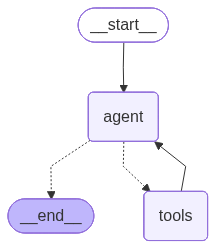

In [7]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from notebooks.utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Mock search result
search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로, 
AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. 
이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 합니다. 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써
AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다.  """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """특정 주제에 대한 정보를 웹에서 검색합니다.

    이 도구는 웹 검색을 수행하고 주어진 쿼리에 대한 관련 결과를 반환합니다.
    인터넷에서 어떤 주제에 대한 정보를 수집해야 할 때 사용하세요.

    Args:
        query: 검색 쿼리 문자열. 찾고자 하는 정보에 대해 구체적이고 명확하게 작성하세요.

    Returns:
        검색 엔진에서 반환된 검색 결과.

    Example:
        web_search(“의료 분야에서의 머신 러닝 응용”)
    """
    return search_result


# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-5-nano", temperature=0.0)
tools = [ls, read_file, write_file, web_search]

# Create agent with system prompt
agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `files` in state and an user research request. 

In [8]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.",
            }
        ],
        "files": {},
    }
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: call_S22j3U4TxEq8p7QFmY3UB0Y4                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "mcp_request.txt",                                                                               │
│   "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요."                                         │
│ }                                                                                                               │
│    ID: call_sXGgjfCdhRYboKnXkyD8uvAL                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file mcp_request.txt                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_request.txt",                                                                               │
│   "offset": 0,                                                                                                  │
│   "limit": 2000                                                                                                 │
│ }                                                                                                               │
│    ID: call_hKwRAyzZBEnjW1iLdgc7Yc1g                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 다음은 모델 컨텍스트 프로토콜(MCP)에 대한 일반적이고 포괄적인 개요입니다. 이는 여러 맥락에서 적용 가능한 개념적 │
│ 프레임으로, 특정 표준이 아니라 설계 가이드로 이해하시면 좋습니다. 필요에 따라 도메인에 맞춰 구체화할 수         │
│ 있습니다.                                                                                                       │
│                                                                                                                 │
│ - MCP의 의의                                                                                                    │
│   - 모델이 처리하는 맥락(context)을 체계적으로 수집, 저장, 관리하고 필요 시 안정적으로 적용하기 위한 표준화된   │
│ 프레임워크.                                                                                                     │
│   - 대화의 일관성, 사용자 맞춤성, 안전성, 재현성 등을 높이기 위한 맥락 관리 원칙을 제공합니다.                  │
│                                                                                                                 │
│ - 핵심 구성 개념                                                                                                │
│   - 맥락 범위: 단기 대화 맥락, 사용자 프로파일, 도메인 지식, 외부 데이터 소스 등 다양한 맥락 소스의 조합 관리.  │
│   - 맥락 소스: 사용자 프롬프트, 시스템 프롬프트, 데이터베이스/지식 베이스, 도구의 출력, 임베딩 및 검색 결과 등. │
│   - 맥락 인코딩과 저장: 텍스트 토큰화, 임베딩, 정보를 압축하거나 구조화된 블록으로 저장.                        │
│   - 맥락 검색과 조합: 필요 시 저장된 맥락을 검색하고, 모델 입력으로 적절히 합성.                                │
│   - 개인정보 및 보안: 최소 데이터 원칙, 동의 관리, 암호화, 접근 제어, 보존 주기 정책.                           │
│   - 버전 관리와 호환성: 맥락 스키마의 버전 관리, 마이그레이션 전략, 역호환성.                                   │
│   - 성능 관리: 토큰 예산 관리, 캐싱, 지연 최소화, 로깅 및 모니터링.                                             │
│   - 상호운용성: 명확한 API 계약, 오류 처리, 관찰 가능성.                                                        │
│                                                                                                                 │
│ - 데이터 모델과 표현 형식                                                                                       │
│   - 맥락 블록(block) 기반 구조: 각 블록은 유형(type), 내용(content), 메타데이터(metadata)로 구성.               │
│   - 메타데이터 예: 출처(source), 타임스탬프(timestamp), 신뢰도(confidence), 버전(version).                      │
│   - 예시 포맷(간단한 JSON 형태의 아이디어):                                                                     │
│     {                                                                                                           │
│       "context_id": "user123-202509",                                                                           │
│       "blocks": [                                                                                               │
│         {"type": "user_profile", "content": {"preferences": ["기술", "과학"]}, "metadata": {"source": "user",   │
│ "timestamp": "2025-09-01T12:00:00Z"}}                                                                           │
│       ],                                                                                                        │
│       "version": 1                                                                                              │
│     }                                                                                                           │
│                                                                                                                 │
│ - 라이프사이클                                                                                                  │
│   - 수집 및 enrichment: 맥락 소스를 모으고 필요 시 보강.                                                        │
│   - 검증 및 정제: 데이터 품질 및 프라이버시 요구사항 충족 여부 확인.                                            │
│   - 저장 및 버전 관리: 맥락을 저장하고 버전으로 관리.                                                           │
│   - 조회 및 합성: 필요 시 맥락을 검색/추출하여 모델 입력에 반영.                                                │
│   - 업데이트 및 삭제: 피드백 반영, 만료된 데이터의 폐기.                                                        │
│                                                                                                    

We can see the file saved in our mock file system. 

In [9]:
result

{'messages': [HumanMessage(content='모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.', additional_kwargs={}, response_metadata={}, id='f0e6b7bc-d414-4462-8ff0-17d6ef178e8f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_S22j3U4TxEq8p7QFmY3UB0Y4', 'function': {'arguments': '{}', 'name': 'ls'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1235, 'prompt_tokens': 833, 'total_tokens': 2068, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1216, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CL0ggFJwtAvy9wO4CMhi1yQGGVr3M', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--93f7e995-c5d0-458a-acd0-8d01ec74ccba-0', tool_calls=[{'name': 'ls', 'args': {}, 'id': 'call_S22j3U4TxEq8p7QFmY3UB0Y4', 'type': 'tool_call'

In [10]:
result["files"]

{'mcp_request.txt': '모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.'}

Trace: 
https://smith.langchain.com/public/b03e20b4-e908-488d-84a9-8f891d17addd/r
<!-- https://smith.langchain.com/public/1066102f-d7b3-423c-b556-006865a1d479/r -->